# XGBoost

In [1]:
import pandas as pd

trainDF = pd.read_csv('../data/filtered/processedData.csv')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

df = trainDF.copy()

# Separate target and features
y = df["SalePrice"]
X = df.drop(columns=["SalePrice"])

# Train/test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Detect categorical columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessor: OneHotEncode categorical, passthrough the rest
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"
)

# Full pipeline: preprocessing + model
model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

# Fit model
model.fit(X_train, y_train)

# Predict and evaluate
preds = model.predict(X_valid)
rmse = root_mean_squared_error(y_valid, preds)
print(f"Validation RMSE: {rmse:.2f}")

Validation RMSE: 26300.42


This first model's prediction was off by about 26,300 USD from the sale price

# XGBoost with Grid Search

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

# Log-transform the target
y = np.log1p(df["SalePrice"])
X = df.drop(columns=["SalePrice"])

# Split into train/validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# Preprocessing: One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="passthrough"
)

# Model pipeline
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", XGBRegressor(random_state=42, verbosity=0))
])

# Define hyperparameter grid
param_grid = {
    "regressor__n_estimators": [100, 300],
    "regressor__learning_rate": [0.1, 0.05],
    "regressor__max_depth": [3, 5],
    "regressor__subsample": [0.8],
    "regressor__colsample_bytree": [0.8]
}

# Run grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Predict on validation set
log_preds = grid_search.predict(X_valid)
final_preds = np.expm1(log_preds)
true_vals = np.expm1(y_valid)

# Evaluate
rmse = root_mean_squared_error(true_vals, final_preds)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Validation RMSE (after log-reverse): {rmse:.2f}")

Best Parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}
Validation RMSE (after log-reverse): 25152.99


After log-transforming and hyperparameter tuning, the RMSE dropped to 25152.99, which is an improvement.

# Exploring the most important features

In [4]:
# Get the fitted XGBRegressor from the pipeline
best_model = grid_search.best_estimator_.named_steps["regressor"]

# Get the one-hot encoded feature names
feature_names = grid_search.best_estimator_.named_steps["preprocessing"] \
    .get_feature_names_out()

# Combine feature names with importances
importances = best_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)


In [5]:
print(importance_df)

                    feature  importance
127       cat__ExterQual_TA    0.151325
247  remainder__OverallQual    0.119517
224      cat__GarageCond_TA    0.076020
180       cat__CentralAir_Y    0.046685
259    remainder__GrLivArea    0.038389
..                      ...         ...
151    cat__BsmtExposure_Mn    0.000000
153   cat__BsmtExposure_nan    0.000000
53     cat__Condition1_PosA    0.000000
157   cat__BsmtFinType1_LwQ    0.000000
138    cat__Foundation_Wood    0.000000

[277 rows x 2 columns]


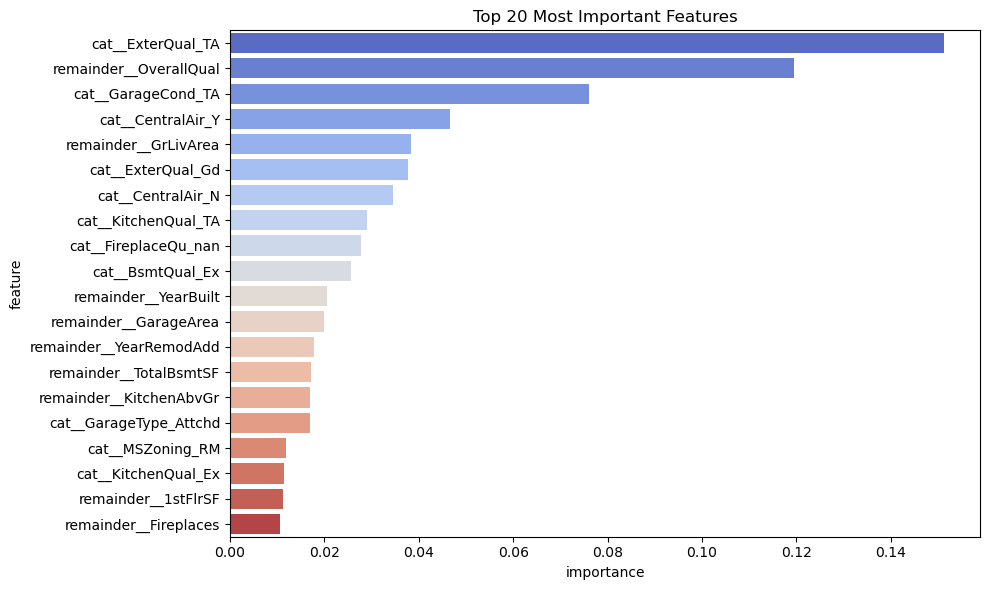

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot top 20 most important features
top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df.head(top_n),
    x="importance",
    y="feature",
    hue="feature",
    palette="coolwarm",
    legend=False
)
plt.title(f"Top {top_n} Most Important Features")
plt.tight_layout()
plt.show()


Features that start with remainder are numerical and the ones that start with cat are categorical.

It seems that ExterQual which evaluates the quality of the material on the exterior, is considered the most important feature here and OverallQual which rates the overall material and finish of the house, is the second most important. This makes sense since the outside quality of the house and the overall quality of the house's ratings would most definitely have an impact of what buyers are willing to pay for it.

# Test Dataset

In [7]:
testDF = pd.read_csv('../data/raw/train.csv')

In [8]:
testDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
# Optional: preserve ID for submission later
testIds = testDF['Id']

# Fill missing categorical with "N/A"
cat_cols = testDF.select_dtypes(include=['object', 'category']).columns
testDF[cat_cols] = testDF[cat_cols].fillna('N/A')

# Fill missing numerical with median
num_cols = testDF.select_dtypes(include=['number']).columns
for col in num_cols:
    if testDF[col].isna().sum() > 0:
        testDF[col] = testDF[col].fillna(testDF[col].median())


In [10]:
# Make predictions (these are in log-space)
log_preds_test = grid_search.best_estimator_.predict(testDF)

# Convert back to real price values
final_preds_test = np.expm1(log_preds_test)


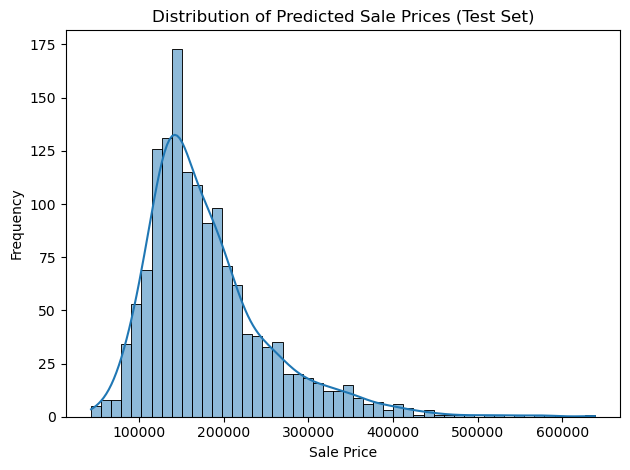

In [11]:
sns.histplot(final_preds_test, bins=50, kde=True)
plt.title("Distribution of Predicted Sale Prices (Test Set)")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [12]:
print("Predicted SalePrice Summary:")
print(f"Min: ${final_preds_test.min():,.2f}")
print(f"Max: ${final_preds_test.max():,.2f}")
print(f"Mean: ${final_preds_test.mean():,.2f}")
print(f"Median: ${np.median(final_preds_test):,.2f}")


Predicted SalePrice Summary:
Min: $43,539.47
Max: $638,299.69
Mean: $181,326.81
Median: $163,609.28


In [17]:
submission = pd.DataFrame({
    'Id': testIds,
    'SalePrice': final_preds_test
})

#submission.to_csv('', index=False)